# Bayesian Analysis of Math Exam Scores

## Problem Statement

You are provided with a dataset of math exam scores from Estonian primary schools. Your task is to build a Bayesian model to better understand the factors that influence exam performance.

## Data Description

The dataset includes the following variables:
- `year`: The year of the exam (2016-2023), with [2020 missing due to the COVID-19 pandemic](https://www.ohtuleht.ee/998159/pohikooli-eksamid-jaavad-ara-riigieksamid-toimuvad)
- `county`: The county where the student took the exam
- `domestic_background`: Whether the student is Estonian or Russian
- `gender`: Student's gender (Male/Female)
- `avg_grade`: The student's average grade (from 1 to 5, continuous)
- `exam_score`: The exam score (0-50 points)


In [24]:
# Import libraries, import and manipulate 
import pandas as pd
import numpy as np
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns
import random

# Load the data
df = pd.read_csv('math_exam_scores.csv', sep=";").sample(4000) # Work with a smaller dataset at first so that you don't have to wait 10 minutes every time you sample the model.
#df = pd.read_csv('math_exam_scores.csv', sep=";") #87669 observations

# DATA MANIPULATIONS #
## YEAR ##
# Convert year to category as there are probably non-linear effects at play
df['year'] = df['year'].astype('category')

# Encode categorical variable 'year' as integers for indexing
df['year'] = df['year'].cat.codes
n_years = df['year'].nunique()

## COUNTY ##
# Make sure county is a category
df['county'] = df['county'].astype('category')

# Encode categorical variable 'county'
df['county'] = df['county'].cat.codes
n_counties = df['county'].nunique()

## GENDER ##
# Convert domestic_background to numerical binary
remap = {'Male': 0, 'Female': 1}
pd.set_option("future.no_silent_downcasting", True)
df['gender'] = df['gender'].replace(remap).values.astype(int)

## DOMESTIC BACKGROUND ##
# Convert domestic_background to numerical binary
remap = {'Estonian': 0, 'Russian': 1}
df['domestic_background'] = df['domestic_background'].replace(remap).values.astype(int)

## CONTINIOUS VARIABLES ##
# Rescaling exam score and since the Beta distribution is the most intuitive choice, then make sure that
#  the rescled exam score is strictly within open interval (0,1), ie. cannot be [0,1].
eps = 1e-6
df['exam_score_rescaled'] = (df['exam_score'] / 50.0).clip(eps, 1-eps)

# Rescaling avg_grade
df['avg_grade_rescaled'] = df['avg_grade'] / 5.0

models = {}

In [25]:
df.describe()

,year,county,domestic_background,gender,exam_score,avg_grade,exam_score_rescaled,avg_grade_rescaled
count,4000.000000,4000.000000,4000.000000,4000.00000,4000.000000,4000.000000,4000.000000,4000.000000
mean,3.153500,4.097500,0.208500,0.49650,37.205750,3.756193,0.744115,0.751239
std,2.038499,4.800339,0.406287,0.50005,10.448263,0.969341,0.208965,0.193868
min,0.000000,0.000000,0.000000,0.00000,0.000000,0.253043,0.000001,0.050609
25%,1.000000,0.000000,0.000000,0.00000,31.000000,3.163936,0.620000,0.632787
50%,3.000000,2.000000,0.000000,0.00000,40.000000,4.002931,0.800000,0.800586
75%,5.000000,8.000000,0.000000,1.00000,46.000000,4.534170,0.920000,0.906834
max,6.000000,14.000000,1.000000,1.00000,50.000000,4.999681,0.999999,0.999936


## Problem analysis

The DAG that we'll take as the basis of our analysis.

<img src="pics/DAG.png" alt="drawing" width="400"/>

### Justification for the DAG

**Year** - Since this standardised matematics exam is administered to the whole country simultaneously in set year, then all of the possible influencing factors are captured in this factor. Exam exercises are changed every year, so [some years tend to be easier](https://www.err.ee/1609007237/pohikooli-matemaatikaeksami-sooritused-olid-paremad-kui-kahel-eelneval-aastal) and some harder, there are global effects that come into play (eg. COVID-19 pandemic), policy changes, cohort effects etc.<br>
Since all other variables result from a progression of longer processes (eg. county effects on exam score) and any shift in them cannot be attributed to a single year, then Year of the exam does not have influence on other factors.

**County** - Differences in school education quality, population parameters (eg. urban/rural porportions), socio/economic factors are encompassed into the county variable. For that reason county is set to influence academic ability and average grade. <br>
The distribution of Estonian and Russian speaking families is different between counties. Therefore count -> domestic_background. 

**Domestic background** - [PISA statistics](https://harno.ee/sites/default/files/documents/2023-12/Pisa_tulemused_2022_veebi.pdf) show that Estonian and Russian students' academic ability differs quite a lot in Estonia.

**Gender** - [PISA statistics](https://harno.ee/sites/default/files/documents/2023-12/Pisa_tulemused_2022_veebi.pdf) show that there is a gap in academic ability between boys and girls in Estonia.

**Academic ability** - Exam score is meant to measure academic ability of a student, but its an approximation. Its taken as a latent variable into the model. Academic ability is influenced by multiple factors such as school education quality, environment (mediated by county), domestic background and gender etc. <br> 
Average grade also tries to measure academic ability, but has other influencing factors at play (eg. group level effects of school and county, girls tend to worry more about grades than boys). So it cannot be taken as the same kind of measure of academic ability as the exam score.

**Average grade** - Average grade is another attempt at measuring academic ability, but is less standardised. It is also dependent on group level effects from schools and thus counties, ie. a '4' in Harjumaa is likely not the same as a '4' in Võrumaa. Since its a an outcome of academic ability, then it is highly correlated with exam score. <br>
Average grade does however influences **the variability of exam score**, ie. students who have average grade near 5 are probably very good at exams and tests. Knowledge enables them to be faster, thus having more time to overlook the exam submission, finding typos and small mistakes. On the opposite end of the spectrum students who have a very low average grade will probably also struggle on the exam, so its vey unlikely they will suddenly score much points on the exam, therefore variability is also lower.


## Let's model

Table of contents:

**Models with Beta distribution:**
1. [Model with only year (model_beta_m1)](#model_beta_m1)
1. [Model with academic ability and year (model_beta_m2)](#model_beta_m2)
1. [Model with academic ability, average grade and year (model_beta_m3)](#model_beta_m3)
1. [Model with academic ability, average grade and year, $\beta$ is variable (model_beta_m4)](#model_beta_m4)
1. [Model with heteroscedacity 4 (model_beta_heterosc4)](#model_beta_heterosc4)
1. [Full luxury Bayes (model_beta_luxury)](#model_beta_luxury)

**Models with Binomial distribution:**
1. [Model with only year (model_binomial_m1)](#model_binomial_m1)
1. [Model with academic ability, average grade and year (model_binomial_m4)](#model_binomial_m4)

**Models with Truncated normal distribution:**
1. [Beta model m2 substituted with Truncated Normal (model_trunc_normal_m2)](#model_trunc_normal_m2)
1. [Best model m4 with Truncated Normal (model_trunc_normal_m4)](#model_trunc_normal_m4)

## With Beta distribution

Since exam score is bounded within [0,50] and with a hockey stick shape (see graph below), then Scaled Beta distribution is the most suitable option. Later there are some tests with Binomial distribution, but binomial is not ideal in this situation.

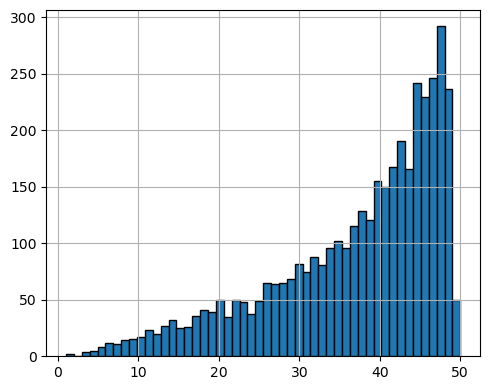

In [5]:
df['exam_score'].hist(bins=50, figsize=(5, 4), edgecolor='black')
plt.tight_layout()
plt.show()

### <a name="model_beta_m1">Model with only year</a>
First a simple model with just year in the mix. 

In [6]:
with pm.Model() as model_beta_m1:
    # Priors
    intercept = pm.Normal("intercept", mu=1, sigma=1)
    beta_year = pm.Normal("beta_year", mu=1, sigma=1, shape=n_years)

    alpha = intercept + beta_year[df.year]
    
    # Likelihood
    y_obs = pm.Beta("y_obs", alpha=alpha, beta=1, observed=df.exam_score_rescaled)
    
    # Sampling
    trace = pm.sample(1000, tune=1000, target_accept=0.9, return_inferencedata=True)
    pm.sample_posterior_predictive(trace, extend_inferencedata=True)
    pm.compute_log_likelihood(trace, extend_inferencedata=True)
    models['model_beta_m1'] = trace

# Summary
az.summary(trace, round_to=2) 

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, beta_year]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 43 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Sampling: [y_obs]


Output()

Output()

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
intercept,1.90,0.38,1.20,2.65,0.02,0.01,375.10,447.71,1.01
beta_year[0],0.56,0.39,-0.18,1.29,0.02,0.01,401.40,502.03,1.01
beta_year[1],0.06,0.38,-0.63,0.81,0.02,0.01,391.04,506.46,1.01
beta_year[2],1.52,0.40,0.77,2.24,0.02,0.01,408.64,534.19,1.01
beta_year[3],0.18,0.39,-0.57,0.91,0.02,0.01,391.46,494.55,1.01
beta_year[4],2.63,0.41,1.83,3.37,0.02,0.01,418.79,526.73,1.01
beta_year[5],2.22,0.40,1.44,3.01,0.02,0.01,427.27,564.65,1.01
beta_year[6],0.63,0.39,-0.09,1.37,0.02,0.01,397.25,483.05,1.01


               mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
intercept     1.958  0.358   1.290    2.642      0.018    0.012     402.0   
beta_year[0]  0.386  0.369  -0.299    1.086      0.018    0.011     433.0   
beta_year[1] -0.218  0.363  -0.855    0.518      0.018    0.011     418.0   
beta_year[2]  1.633  0.379   0.986    2.414      0.018    0.011     465.0   
beta_year[3]  0.118  0.366  -0.545    0.838      0.018    0.011     414.0   
beta_year[4]  2.655  0.396   1.860    3.353      0.018    0.011     490.0   
beta_year[5]  2.699  0.392   1.963    3.406      0.018    0.011     457.0   
beta_year[6]  0.654  0.368  -0.063    1.339      0.018    0.012     415.0   

              ess_tail  r_hat  
intercept        465.0   1.00  
beta_year[0]     504.0   1.00  
beta_year[1]     513.0   1.00  
beta_year[2]     695.0   1.00  
beta_year[3]     544.0   1.00  
beta_year[4]     697.0   1.00  
beta_year[5]     543.0   1.01  
beta_year[6]     584.0   1.00  


array([[<Axes: title={'center': 'intercept'}>,
        <Axes: title={'center': 'intercept'}>],
       [<Axes: title={'center': 'beta_year'}>,
        <Axes: title={'center': 'beta_year'}>]], dtype=object)

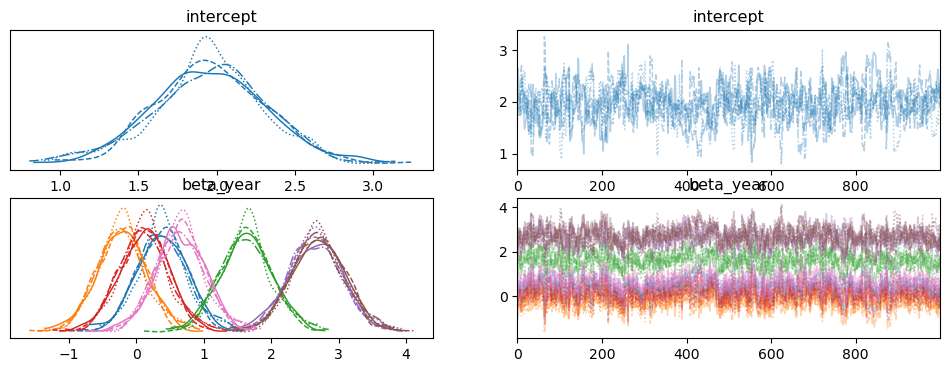

In [9]:
# Model diagnostics
print(pm.summary(trace))
pm.plot_trace(trace)

<Axes: xlabel='y_obs'>

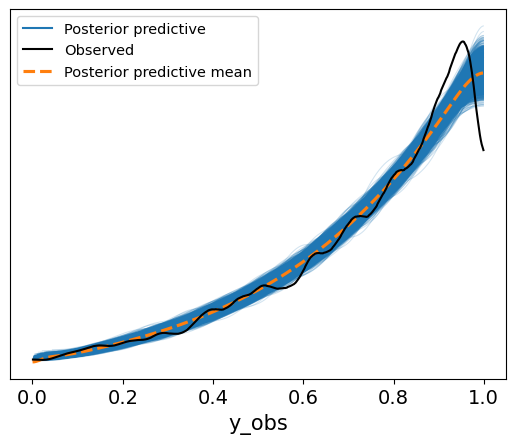

In [10]:
pm.plot_ppc(trace)

### <a name="model_beta_m2">Model with academic ability and year (model_beta_m2)</a>

Model with latent academic ability added to the model.

In [7]:
with pm.Model() as model_beta_m2:
    # Priors
    acad_intercept = pm.Normal("acad_intercept", mu=0, sigma=1)
    beta_gender = pm.Normal("beta_gender", mu=0, sigma=1)
    beta_domestic = pm.Normal("beta_domestic", mu=0, sigma=1)
    beta_county = pm.Normal("beta_county", mu=0, sigma=1, shape=n_counties)
    
    # Latent variable: academic ability
    mu = (acad_intercept
        + beta_gender * df.gender
        + beta_domestic * df.domestic_background
        + beta_county[df.county])
    academic_ability = pm.Normal("academic_ability", mu=mu, sigma=1)

    # Priors for exam score
    beta_year = pm.Normal("beta_year", mu=0, sigma=1, shape=n_years)
    beta_academic = pm.Normal("beta_academic", mu=0, sigma=1)
    alpha_intercept = pm.Normal("alpha_intercept", mu=0, sigma=1)

    # Since sigmoid converts into (0,1) interval, but alpha is probably higher so that higher exam score values
    #  would be more prevalent, so the sigmoid is multiplied by 6
    alpha = pm.math.sigmoid(alpha_intercept + beta_academic * academic_ability + beta_year[df.year.values]) * 6
    
    # Likelihood
    y_obs = pm.Beta("y_obs", alpha=alpha, beta=1, observed=df.exam_score_rescaled)
        
    # Sampling
    trace = pm.sample(1000, tune=1000, target_accept=0.9, return_inferencedata=True)
    pm.sample_posterior_predictive(trace, extend_inferencedata=True)
    pm.compute_log_likelihood(trace, extend_inferencedata=True)
    models['model_beta_m2'] = trace

# Summary
var_names=[c for c in list(trace.posterior.data_vars) if not(c.startswith('academic_ability'))]
az.summary(trace, round_to=2, var_names=var_names) 

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [acad_intercept, beta_gender, beta_domestic, beta_county, academic_ability, beta_year, beta_academic, alpha_intercept]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 160 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Sampling: [y_obs]


Output()

Output()

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
acad_intercept,0.11,0.68,-1.12,1.29,0.28,0.10,6.04,20.41,1.77
beta_gender,-0.07,0.27,-0.65,0.38,0.06,0.03,16.98,57.15,1.20
beta_domestic,-0.16,0.39,-0.84,0.58,0.13,0.03,9.96,47.46,1.32
beta_county[0],-0.19,0.53,-1.09,0.91,0.19,0.09,8.26,27.59,1.44
beta_county[1],-0.00,0.85,-1.50,1.69,0.05,0.03,324.64,570.34,1.00
beta_county[2],-0.17,0.62,-1.30,1.02,0.20,0.05,9.53,59.12,1.36
beta_county[3],0.09,0.71,-1.17,1.45,0.07,0.05,122.09,127.61,1.03
beta_county[4],-0.63,1.37,-2.53,2.17,0.61,0.29,6.89,37.24,1.59
beta_county[5],0.41,0.90,-1.40,1.93,0.36,0.16,7.64,35.67,1.52
beta_county[6],0.15,0.72,-1.13,1.53,0.13,0.02,32.09,467.05,1.11


<Axes: xlabel='y_obs'>

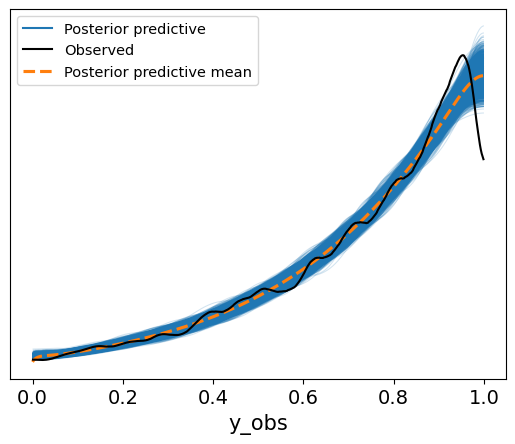

In [13]:
pm.plot_ppc(trace)

### <a name="model_beta_m3">Model with academic ability, average grade and year (model_beta_m3)</a>

Previous model, but average grade is added as a predictor of exam score.

In [8]:
with pm.Model() as model_beta_m3:
    # Priors of the main model
    acad_intercept = pm.Normal("acad_intercept", mu=0, sigma=1)
    beta_gender = pm.Normal("beta_gender", mu=0, sigma=1)
    beta_domestic = pm.Normal("beta_domestic", mu=0, sigma=1)
    beta_county = pm.Normal("beta_county", mu=0, sigma=1, shape=n_counties)

    # Latent variable: academic ability
    mu = (acad_intercept
        + beta_gender * df.gender
        + beta_domestic * df.domestic_background
        + beta_county[df.county])
    academic_ability = pm.Normal("academic_ability", mu=mu, sigma=1)

    # Priors for exam score
    alpha_intercept = pm.Normal("alpha_intercept", mu=0, sigma=1)
    beta_academic = pm.Normal("beta_academic", mu=0, sigma=1)
    beta_grade = pm.Normal("beta_grade", mu=0, sigma=1)
    beta_year = pm.Normal("beta_year", mu=0, sigma=1, shape=n_years)

    # Since sigmoid converts into (0,1) interval, but alpha is probably higher so that higher exam score values
    #  would be more prevalent, so the sigmoid is multiplied by 6
    alpha = pm.math.sigmoid(alpha_intercept + beta_academic*academic_ability + beta_grade*df.avg_grade + beta_year[df.year.values]) * 6
    
    # Likelihood
    y_obs = pm.Beta("y_obs", alpha=alpha, beta=1, observed=df.exam_score_rescaled)
        
    # Sampling
    trace = pm.sample(1000, tune=1000, target_accept=0.9, return_inferencedata=True)
    pm.sample_posterior_predictive(trace, extend_inferencedata=True)
    pm.compute_log_likelihood(trace, extend_inferencedata=True)
    models['model_beta_m3'] = trace

# Summary
var_names=[c for c in list(trace.posterior.data_vars) if not(c.startswith('academic_ability'))]
az.summary(trace, round_to=2, var_names=var_names) 

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [acad_intercept, beta_gender, beta_domestic, beta_county, academic_ability, alpha_intercept, beta_academic, beta_grade, beta_year]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 194 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Sampling: [y_obs]


Output()

Output()

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
acad_intercept,0.41,0.89,-1.23,2.12,0.35,0.18,6.29,16.23,1.69
beta_gender,0.43,0.83,-1.03,1.84,0.34,0.09,6.35,88.20,1.77
beta_domestic,-0.40,1.26,-2.01,2.34,0.56,0.31,6.71,33.30,1.63
beta_county[0],-0.17,0.94,-1.82,1.70,0.36,0.17,6.99,23.11,1.58
beta_county[1],-0.00,1.03,-1.91,1.94,0.05,0.03,381.96,533.92,1.01
beta_county[2],-0.42,1.04,-2.11,1.77,0.33,0.22,11.04,26.01,1.30
beta_county[3],0.06,1.00,-1.70,1.99,0.10,0.04,99.01,290.22,1.05
beta_county[4],-0.26,0.97,-1.98,1.61,0.11,0.03,75.00,352.91,1.06
beta_county[5],0.51,1.08,-1.59,2.50,0.31,0.11,12.36,31.91,1.27
beta_county[6],-0.03,0.97,-1.86,1.76,0.08,0.03,143.32,503.88,1.03


<Axes: xlabel='y_obs'>

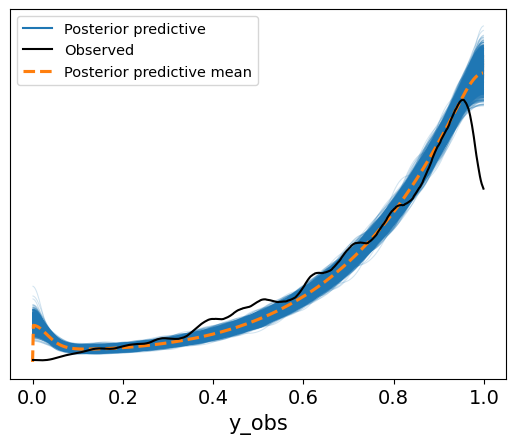

In [16]:
pm.plot_ppc(trace)

## <a name="model_beta_m4">Model with academic ability, average grade and year, $\beta$ is variable (model_beta_m4)</a>

Currently $\beta$ parameter in the Beta distribution is fixed, so let this vary as well.

In [9]:
with pm.Model() as model_beta_m4:    
    # Priors
    acad_intercept = pm.Normal("acad_intercept", mu=0, sigma=1)
    beta_gender = pm.Normal("beta_gender", mu=0, sigma=1)
    beta_domestic = pm.Normal("beta_domestic", mu=0, sigma=1)
    beta_county = pm.Normal("beta_county", mu=0, sigma=1, shape=n_counties)
    
    # Latent variable: academic ability
    mu = (acad_intercept
        + beta_gender * df.gender
        + beta_domestic * df.domestic_background
        + beta_county[df.county])
    academic_ability = pm.Normal("academic_ability", mu=mu, sigma=1)

    # Priors for exam score
    alpha_intercept = pm.Normal("alpha_intercept", mu=0, sigma=1)
    beta_academic = pm.Normal("beta_academic", mu=0, sigma=1)
    beta_grade = pm.Normal("beta_grade", mu=0, sigma=1)
    beta_year = pm.Normal("beta_year", mu=0, sigma=1, shape=n_years)

    alpha = pm.math.sigmoid(alpha_intercept + beta_academic*academic_ability + beta_grade*df.avg_grade + beta_year[df.year.values]) * 6
    beta = pm.Gamma('beta', alpha=2, beta=1)
    
    # Likelihood
    y_obs = pm.Beta("y_obs", alpha=alpha, beta=beta, observed=df.exam_score_rescaled) * 50.0
        
    # Sampling
    trace = pm.sample(1000, tune=1000, target_accept=0.9, return_inferencedata=True)
    pm.sample_posterior_predictive(trace, extend_inferencedata=True)
    pm.compute_log_likelihood(trace, extend_inferencedata=True)
    models['model_beta_m4'] = trace

# Summary
var_names=[c for c in list(trace.posterior.data_vars) if not(c.startswith('academic_ability'))]
az.summary(trace, round_to=2, var_names=var_names) 

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [acad_intercept, beta_gender, beta_domestic, beta_county, academic_ability, alpha_intercept, beta_academic, beta_grade, beta_year, beta]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 220 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Sampling: [y_obs]


Output()

Output()

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
acad_intercept,-0.12,0.90,-1.60,1.52,0.36,0.14,6.45,22.39,1.65
beta_gender,0.11,0.66,-1.02,1.44,0.15,0.07,20.01,52.39,1.13
beta_domestic,0.09,1.00,-1.79,1.90,0.35,0.11,8.32,65.80,1.41
beta_county[0],-0.04,1.36,-2.26,2.32,0.58,0.22,5.85,27.12,1.84
beta_county[1],-0.02,1.01,-1.93,1.96,0.04,0.02,607.21,1011.65,1.01
beta_county[2],-0.01,0.94,-1.69,1.80,0.24,0.07,15.87,90.56,1.18
beta_county[3],0.02,0.92,-1.80,1.66,0.08,0.04,147.58,278.94,1.03
beta_county[4],0.02,1.06,-2.07,1.97,0.09,0.05,127.47,236.75,1.05
beta_county[5],-0.06,1.11,-2.12,1.94,0.17,0.07,41.82,123.46,1.08
beta_county[6],-0.05,1.03,-2.11,1.78,0.06,0.03,265.06,500.21,1.00


<Axes: xlabel='y_obs'>

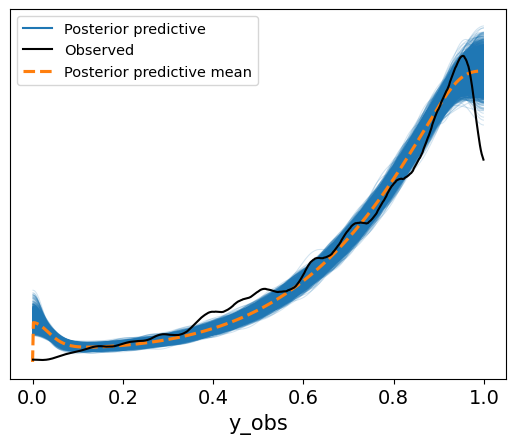

In [90]:
pm.plot_ppc(trace)

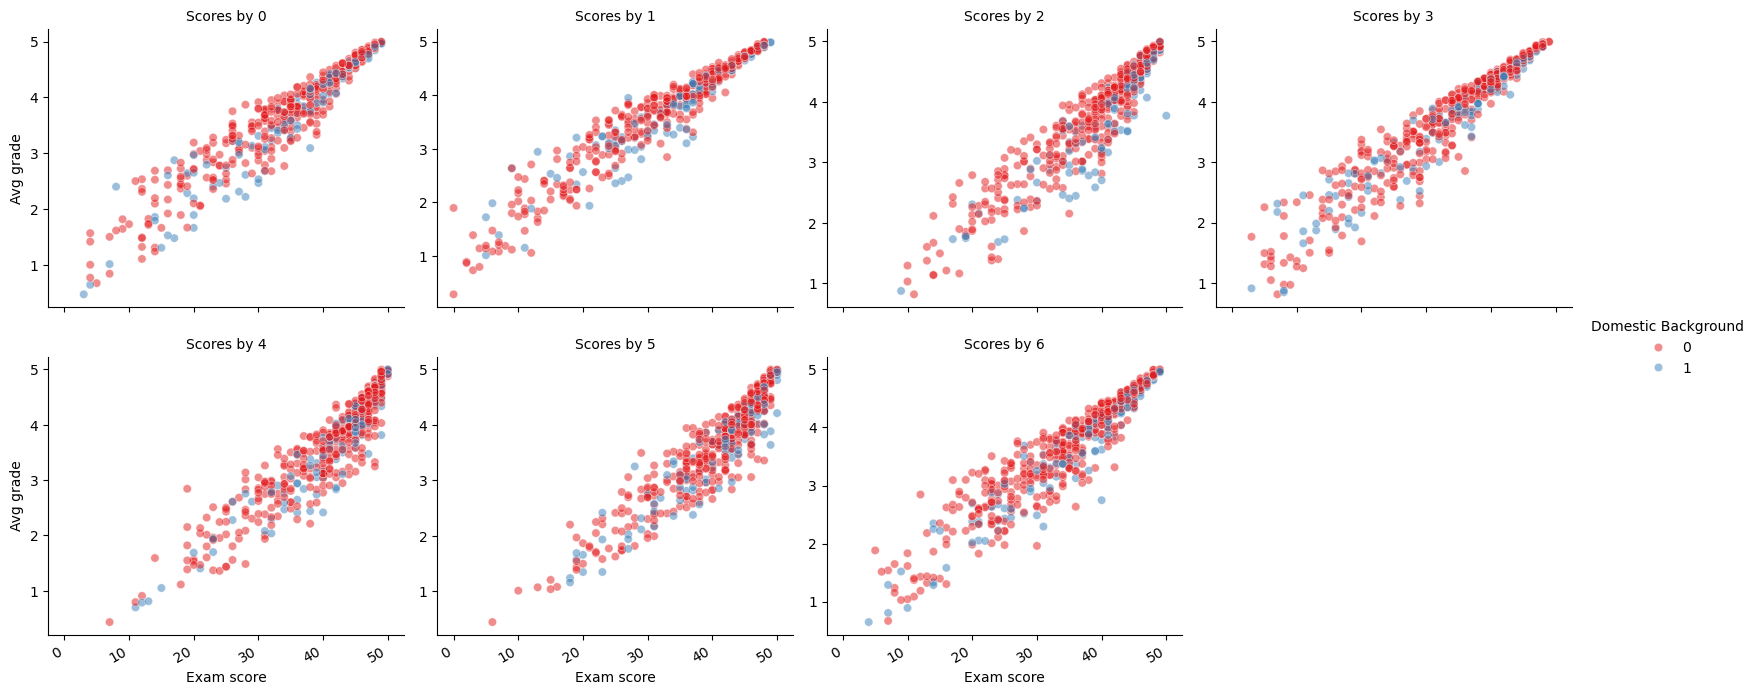

In [21]:
g = sns.FacetGrid(df, col='year', sharey=False, height=4, col_wrap=4)
g.map_dataframe(sns.scatterplot, x="exam_score", y="avg_grade", hue="domestic_background", palette="Set1", alpha=0.5)
g.set_axis_labels("Exam score", "Avg grade")
g.set_titles("Scores by {col_name}")
g.fig.autofmt_xdate()
g.add_legend(title="Domestic Background")
plt.show()

## <a name="model_beta_heterosc1">Model with heteroscedacity 4 (model_beta_heterosc4)</a>

Same as model_beta_heterosc3 with re-parametrization of the Beta distribution but `avg_grade` is also added as a predictor.

In [11]:
random.seed(1234)
with pm.Model() as model_beta_heterosc4:    
    # Priors to modeling academic_ability
    acad_intercept = pm.Normal("acad_intercept", mu=0, sigma=1)
    beta_gender = pm.Normal("beta_gender", mu=0, sigma=1)
    beta_domestic = pm.Normal("beta_domestic", mu=0, sigma=1)
    beta_county = pm.Normal("beta_county", mu=0, sigma=1, shape=n_counties)
    
    # Latent variable: academic ability
    mu = (acad_intercept
        + beta_gender * df.gender
        + beta_domestic * df.domestic_background
        + beta_county[df.county])
    academic_ability = pm.Normal("academic_ability", mu=mu, sigma=1)

    # Priors to modeling exam score
    phi_intercept = pm.Normal("phi_intercept", mu=0, sigma=1)
    kappa_intercept = pm.Normal("kappa_intercept", mu=0, sigma=1)
    beta_academic = pm.Normal("beta_academic", mu=0, sigma=1)
    beta_year = pm.Normal("beta_year", mu=0, sigma=1, shape=n_years)
    beta_grade1 = pm.Normal("beta_grade1", mu=0, sigma=1)
    beta_grade2 = pm.Normal("beta_grade2", mu=0, sigma=1)

    # Based on https://distribution-explorer.github.io/continuous/beta.html trying to reparametrize with phi and kappa 
    # Where phi is the mean and kappa is variance
    phi = pm.math.sigmoid(phi_intercept + beta_academic*academic_ability + beta_grade1*df.avg_grade + beta_year[df.year])
    kappa = kappa_intercept + beta_grade2 * df.avg_grade
    
    y_obs = pm.Beta("y_obs", alpha=phi*kappa, beta=(1-phi)*kappa, observed=df.exam_score_rescaled)
        
    # Sampling
    trace = pm.sample(1000, tune=1000, target_accept=0.9, return_inferencedata=True)
    pm.sample_posterior_predictive(trace, extend_inferencedata=True)
    pm.compute_log_likelihood(trace, extend_inferencedata=True)
    models['model_beta_heterosc4'] = trace

# Summary
var_names=[c for c in list(trace.posterior.data_vars) if not(c.startswith('academic_ability') or c.startswith('heteroscedacity_component'))]
az.summary(trace, round_to=2, var_names=var_names) 

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [acad_intercept, beta_gender, beta_domestic, beta_county, academic_ability, phi_intercept, kappa_intercept, beta_academic, beta_year, beta_grade1, beta_grade2]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 495 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Sampling: [y_obs]


Output()

Output()

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
acad_intercept,-0.52,0.84,-1.92,1.06,0.38,0.16,5.08,13.38,2.23
beta_gender,0.11,0.08,-0.04,0.27,0.00,0.00,1275.58,2043.03,1.00
beta_domestic,0.43,0.12,0.21,0.66,0.00,0.00,770.66,1465.07,1.00
beta_county[0],0.60,0.28,0.08,1.14,0.01,0.01,533.99,1311.08,1.03
beta_county[1],-0.70,0.50,-1.67,0.21,0.01,0.01,1280.00,2032.88,1.01
beta_county[2],1.23,0.33,0.62,1.84,0.01,0.01,506.23,1338.66,1.03
beta_county[3],-0.55,0.36,-1.26,0.11,0.01,0.01,1100.28,2097.10,1.01
beta_county[4],1.64,0.41,0.84,2.36,0.02,0.01,689.87,1333.56,1.01
beta_county[5],-0.90,0.33,-1.50,-0.28,0.01,0.01,655.39,1325.53,1.02
beta_county[6],0.08,0.41,-0.71,0.86,0.01,0.01,1197.42,1948.60,1.01


<Axes: xlabel='y_obs'>

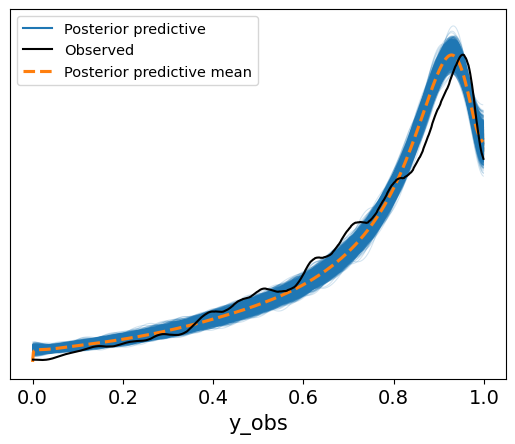

In [122]:
pm.plot_ppc(trace)

## Full luxury Bayes (model_beta_luxury) <a name="model_beta_luxury"></a>

Let's model the full luxury Bayes model where everything is modelled like the DAG implies.

In [12]:
with pm.Model() as model_beta_luxury:  
    # Domestic background
    db_intercept = pm.Normal("db_intercept", mu=0, sigma=1)
    db_beta_county = pm.Normal("db_beta_county", mu=0, sigma=1, shape=n_counties)
    db_logit_p = db_intercept + db_beta_county[df.county]
    domestic = pm.Bernoulli("domestic", logit_p=db_logit_p, observed=df.domestic_background)

    # Priors for academic ability
    acad_intercept = pm.Normal("acad_intercept", mu=0, sigma=1)
    acad_beta_gender = pm.Normal("acad_beta_gender", mu=0, sigma=1)
    acad_beta_domestic = pm.Normal("acad_beta_domestic", mu=0, sigma=1)
    acad_beta_county = pm.Normal("acad_beta_county", mu=0, sigma=1, shape=n_counties)

    # Latent variable: academic ability
    mu = (acad_intercept
        + acad_beta_gender * df.gender
        + acad_beta_domestic * domestic
        + acad_beta_county[df.county])
    academic_ability = pm.Normal("academic_ability", mu=mu, sigma=1)
    
    # Average grade
    ag_intercept = pm.Normal("ag_intercept", mu=0, sigma=1)
    ag_beta_gender = pm.Normal("ag_beta_gender", mu=0, sigma=1)
    ag_beta_academic = pm.Normal("ag_beta_academic", mu=0, sigma=1)
    ag_beta_county = pm.Normal("ag_beta_county", mu=0, sigma=1, shape=n_counties)
    #ag_beta = pm.Gamma('ag_beta', alpha=2, beta=1)
    
    ag_alpha = pm.math.sigmoid(ag_intercept + ag_beta_gender*df.gender + ag_beta_academic*academic_ability + ag_beta_county[df.county]) * 6
    
    grade = pm.Beta("grade", alpha=ag_alpha, beta=1, observed=df.avg_grade_rescaled)    

    # Priors for calculating exam score
    phi_intercept = pm.Normal("phi_intercept", mu=0, sigma=1)
    kappa_intercept = pm.Normal("kappa_intercept", mu=0, sigma=1)
    beta_academic = pm.Normal("beta_academic", mu=0, sigma=1)
    beta_year = pm.Normal("acad_beta_year", mu=0, sigma=1, shape=n_years)
    beta_grade1 = pm.Normal("beta_grade1", mu=0, sigma=1)
    beta_grade2 = pm.Normal("beta_grade2", mu=0, sigma=1)
    
    # Based on https://distribution-explorer.github.io/continuous/beta.html trying to reparametrize with phi and kappa 
    # Where phi is the mean and kappa is variance
    phi = pm.math.sigmoid(phi_intercept + beta_academic*academic_ability + beta_grade1*df.avg_grade + beta_year[df.year])
    kappa = kappa_intercept + beta_grade2 * df.avg_grade

    # Likelihood
    # Heteroscedacity - A 0-centered random noise is added to each observation with variability 0 when average grade is near 0 or 5.
    y_obs = pm.Beta("y_obs", alpha=phi*kappa, beta=(1-phi)*kappa, observed=df.exam_score_rescaled)
        
    # Sampling
    trace = pm.sample(1000, tune=1000, target_accept=0.9, return_inferencedata=True)
    pm.sample_posterior_predictive(trace, extend_inferencedata=True)
    pm.compute_log_likelihood(trace, extend_inferencedata=True)
    models['model_beta_luxury'] = trace

# Summary
var_names=[c for c in list(trace.posterior.data_vars) if not(c.startswith('academic_ability') or c.startswith('heteroscedacity_component'))]
az.summary(trace, round_to=2, var_names=var_names) 

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [db_intercept, db_beta_county, acad_intercept, acad_beta_gender, acad_beta_domestic, acad_beta_county, academic_ability, ag_intercept, ag_beta_gender, ag_beta_academic, ag_beta_county, phi_intercept, kappa_intercept, beta_academic, acad_beta_year, beta_grade1, beta_grade2]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1594 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Sampling: [academic_ability, domestic, grade, y_obs]


Output()

Output()

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
db_intercept,-2.58,0.27,-3.08,-2.07,0.01,0.00,1446.49,2163.80,1.00
db_beta_county[0],1.52,0.28,0.99,2.02,0.01,0.00,1450.66,2146.66,1.00
db_beta_county[1],-0.97,0.76,-2.45,0.40,0.01,0.02,9241.98,2650.66,1.00
db_beta_county[2],3.29,0.29,2.76,3.84,0.01,0.00,1575.43,2439.21,1.00
db_beta_county[3],-1.26,0.61,-2.37,-0.09,0.01,0.01,5666.06,2711.57,1.00
...,...,...,...,...,...,...,...,...,...
acad_beta_year[4],0.40,0.36,-0.29,1.08,0.01,0.01,1167.67,1671.47,1.01
acad_beta_year[5],0.20,0.36,-0.52,0.85,0.01,0.01,1167.44,1702.77,1.01
acad_beta_year[6],-0.62,0.36,-1.32,0.04,0.01,0.01,1157.23,1629.72,1.01
beta_grade1,1.21,0.01,1.19,1.23,0.00,0.00,1051.87,2232.43,1.00


array([<Axes: xlabel='domestic'>, <Axes: xlabel='grade'>,
       <Axes: xlabel='y_obs'>], dtype=object)

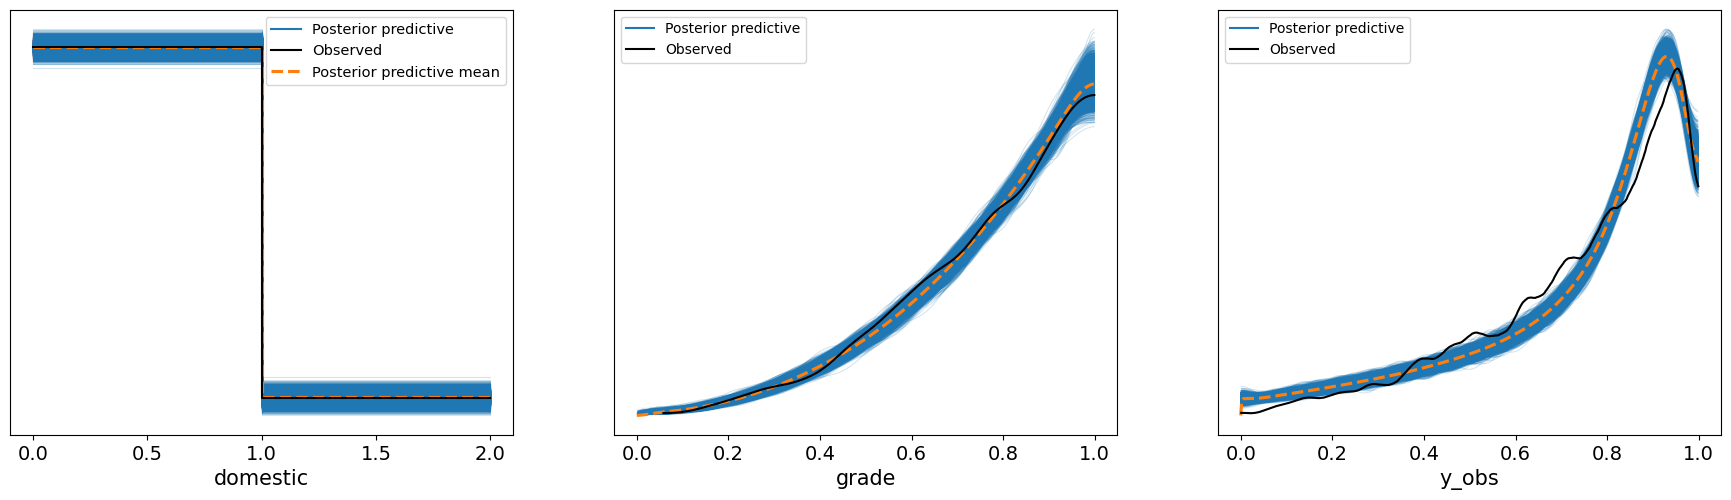

In [155]:
pm.plot_ppc(trace)

## With Binomial distribution (model_binomial_m1)

Let's also start off simple with just `year` in the model.

In [13]:
# Binomial model with year
with pm.Model() as model_binomial_m1:
    # Priors
    intercept = pm.Normal("intercept", mu=1, sigma=1)
    beta_year = pm.Normal("beta_year", mu=1, sigma=1, shape=n_years)

    # Logistic regression model
    logit_p = intercept + beta_year[df.year]
    
    # Likelihood
    y_obs = pm.Binomial("y_obs", n=50, logit_p=logit_p, observed=df.exam_score)
        
    # Sampling
    trace = pm.sample(1000, tune=1000, target_accept=0.9, return_inferencedata=True)
    pm.sample_posterior_predictive(trace, extend_inferencedata=True)
    pm.compute_log_likelihood(trace, extend_inferencedata=True)
    models['model_binomial_m1'] = trace

# Summary
az.summary(trace, round_to=2) 

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, beta_year]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 62 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Sampling: [y_obs]


Output()

Output()

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
intercept,0.20,0.34,-0.46,0.78,0.02,0.01,213.40,224.36,1.02
beta_year[0],0.71,0.34,0.14,1.39,0.02,0.01,213.70,217.20,1.02
beta_year[1],0.46,0.34,-0.11,1.13,0.02,0.01,213.65,225.90,1.02
beta_year[2],1.06,0.34,0.48,1.72,0.02,0.01,214.99,230.78,1.02
beta_year[3],0.53,0.34,-0.06,1.19,0.02,0.01,213.38,226.78,1.02
beta_year[4],1.40,0.34,0.82,2.07,0.02,0.01,215.50,235.34,1.02
beta_year[5],1.27,0.34,0.68,1.93,0.02,0.01,212.04,230.12,1.02
beta_year[6],0.73,0.34,0.16,1.40,0.02,0.01,212.67,230.67,1.02


<Axes: xlabel='y_obs'>

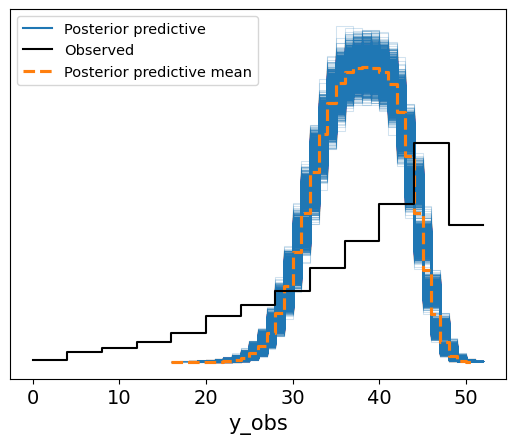

In [31]:
pm.plot_ppc(trace)

### Binomial distribution (model_binomial_m4)

Let's fit a more complex model like the m4 for Beta distribution.

In [14]:
with pm.Model() as model_binomial_m4:
    # Priors for academic ability
    acad_intercept = pm.Normal("acad_intercept", mu=0, sigma=1)
    beta_gender = pm.Normal("beta_gender", mu=0, sigma=1)
    beta_domestic = pm.Normal("beta_domestic", mu=0, sigma=1)
    beta_county = pm.Normal("beta_county", mu=0, sigma=1, shape=n_counties)
        
    # Latent variable: academic ability
    mu = (acad_intercept
        + beta_gender * df.gender
        + beta_domestic * df.domestic_background
        + beta_county[df.county])
    academic_ability = pm.Normal("academic_ability", mu=mu, sigma=1)

    # Priors for exam score
    alpha_intercept = pm.Normal("alpha_intercept", mu=0, sigma=1)
    beta_year = pm.Normal("beta_year", mu=0, sigma=1, shape=n_years)
    beta_academic = pm.Normal("beta_academic", mu=0, sigma=1)
    beta_grade = pm.Normal("beta_grade", mu=0, sigma=1)
    
    # Logistic regression model
    logit_p = alpha_intercept + beta_academic * academic_ability + beta_grade*df.avg_grade + beta_year[df.year.values]
    
    # Likelihood
    y_obs = pm.Binomial("y_obs", n=50, logit_p=logit_p, observed=df.exam_score)
        
    # Sampling
    trace = pm.sample(1000, tune=1000, target_accept=0.9, return_inferencedata=True)
    pm.sample_posterior_predictive(trace, extend_inferencedata=True)
    pm.compute_log_likelihood(trace, extend_inferencedata=True)
    models['model_binomial_m4'] = trace

# Summary
var_names=[c for c in list(trace.posterior.data_vars) if not(c.startswith('academic_ability') or c.startswith('heteroscedacity_component'))]
az.summary(trace, round_to=2, var_names=var_names) 

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [acad_intercept, beta_gender, beta_domestic, beta_county, academic_ability, alpha_intercept, beta_year, beta_academic, beta_grade]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 322 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Sampling: [y_obs]


Output()

Output()

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
acad_intercept,1.05,0.64,-0.09,2.19,0.23,0.08,7.63,22.54,1.48
beta_gender,0.00,0.12,-0.20,0.22,0.05,0.00,7.14,164.07,1.55
beta_domestic,0.00,0.39,-0.53,0.55,0.19,0.00,6.12,132.00,1.74
beta_county[0],0.08,0.64,-0.92,1.07,0.29,0.01,6.13,157.74,1.75
beta_county[1],0.05,0.88,-1.47,1.47,0.38,0.01,6.39,143.38,1.68
beta_county[2],0.08,1.13,-1.48,1.59,0.55,0.01,6.11,148.49,1.76
beta_county[3],0.06,0.53,-0.82,1.06,0.21,0.01,6.98,167.78,1.57
beta_county[4],0.09,1.50,-1.91,2.14,0.73,0.01,6.15,137.87,1.74
beta_county[5],0.06,0.96,-1.29,1.47,0.45,0.01,6.09,102.51,1.76
beta_county[6],0.06,0.43,-0.75,0.83,0.09,0.01,25.19,784.45,1.11


<Axes: xlabel='y_obs'>

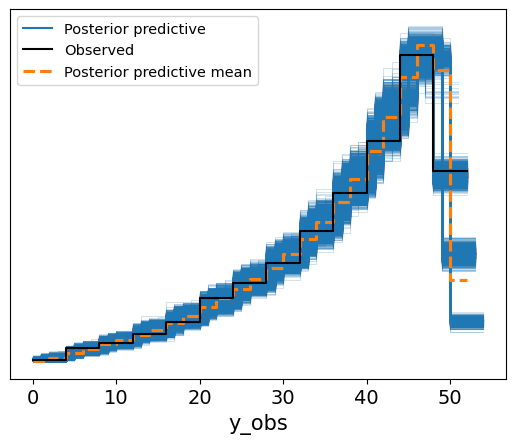

In [94]:
pm.plot_ppc(trace)

## Truncated normal

In [75]:
with pm.Model() as model_trunc_normal_m2:    
    # Priors
    acad_intercept = pm.Normal("acad_intercept", mu=0, sigma=1)
    beta_gender = pm.Normal("beta_gender", mu=0, sigma=1)
    beta_domestic = pm.Normal("beta_domestic", mu=0, sigma=1)
    beta_county = pm.Normal("beta_county", mu=0, sigma=1, shape=n_counties)
    
    # Latent variable: academic ability
    mu = (acad_intercept
        + beta_gender * df.gender
        + beta_domestic * df.domestic_background
        + beta_county[df.county])
    academic_ability = pm.Normal("academic_ability", mu=mu, sigma=1)

    # Priors for exam score
    alpha_intercept = pm.Normal("alpha_intercept", mu=0, sigma=1)
    beta_academic = pm.Normal("beta_academic", mu=0, sigma=1)
    beta_grade = pm.Normal("beta_grade", mu=0, sigma=1)
    beta_year = pm.Normal("beta_year", mu=0, sigma=1, shape=n_years)

    mu = alpha_intercept + beta_academic*academic_ability + beta_year[df.year.values]
    sigma = beta_grade*(df.avg_grade*(5-df.avg_grade))
    
    # Likelihood
    y_obs = pm.TruncatedNormal("y_obs", mu=mu, sigma=sigma, lower=0, upper=50, observed=df.exam_score)
        
    # Sampling
    trace = pm.sample(1000, tune=1000, target_accept=0.9, return_inferencedata=True)
    pm.sample_posterior_predictive(trace, extend_inferencedata=True)
    pm.compute_log_likelihood(trace, extend_inferencedata=True)
    models['model_trunc_normal_m2'] = trace

# Summary
var_names=[c for c in list(trace.posterior.data_vars) if not(c.startswith('academic_ability'))]
az.summary(trace, round_to=2, var_names=var_names) 

Computing ... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 0:00:00

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
acad_intercept,5.16,8.82,-11.30,11.74,4.38,2.54,4.81,10.96,2.52
beta_gender,0.01,0.10,-0.18,0.19,0.01,0.00,253.63,571.10,1.01
beta_domestic,0.10,0.20,-0.31,0.42,0.08,0.03,8.15,34.52,1.47
beta_county[0],0.50,0.88,-1.28,1.43,0.42,0.23,6.74,41.03,1.64
beta_county[1],0.28,0.75,-1.12,1.61,0.23,0.06,11.49,41.45,1.28
beta_county[2],0.57,1.02,-1.41,1.74,0.48,0.27,6.85,25.07,1.64
beta_county[3],0.22,0.48,-0.66,1.14,0.15,0.05,10.91,38.16,1.29
beta_county[4],0.65,1.15,-1.72,1.94,0.54,0.29,7.12,30.45,1.56
beta_county[5],0.19,0.41,-0.62,0.87,0.14,0.04,9.22,44.53,1.37
beta_county[6],0.40,0.91,-1.48,1.80,0.38,0.19,7.46,31.57,1.54


<Axes: xlabel='y_obs'>

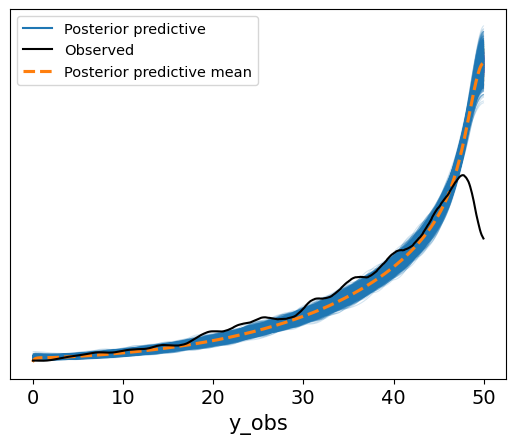

In [36]:
pm.plot_ppc(trace)

In [15]:
with pm.Model() as model_trunc_normal_m4:    
    # Priors
    acad_intercept = pm.Normal("acad_intercept", mu=0, sigma=1)
    beta_gender = pm.Normal("beta_gender", mu=0, sigma=1)
    beta_domestic = pm.Normal("beta_domestic", mu=0, sigma=1)
    beta_county = pm.Normal("beta_county", mu=0, sigma=1, shape=n_counties)
    
    # Latent variable: academic ability
    mu = (acad_intercept
        + beta_gender * df.gender
        + beta_domestic * df.domestic_background
        + beta_county[df.county])
    academic_ability = pm.Normal("academic_ability", mu=mu, sigma=1)

    # Priors for exam score
    mu_intercept = pm.Normal("mu_intercept", mu=0, sigma=1)
    sigma_intercept = pm.Normal("sigma_intercept", mu=0, sigma=1)
    beta_academic = pm.Normal("beta_academic", mu=0, sigma=1)
    beta_grade1 = pm.Normal("beta_grade1", mu=0, sigma=1)
    beta_grade2 = pm.Normal("beta_grade2", mu=0, sigma=1)
    beta_year = pm.Normal("beta_year", mu=0, sigma=1, shape=n_years)

    mu = mu_intercept + beta_academic*academic_ability + beta_grade1*df.avg_grade + beta_year[df.year.values]
    sigma = sigma_intercept + beta_grade2*(df.avg_grade)
    
    # Likelihood
    y_obs = pm.TruncatedNormal("y_obs", mu=mu, sigma=sigma, lower=0, upper=50, observed=df.exam_score)
        
    # Sampling
    trace = pm.sample(1000, tune=1000, target_accept=0.9, return_inferencedata=True)
    pm.sample_posterior_predictive(trace, extend_inferencedata=True)
    pm.compute_log_likelihood(trace, extend_inferencedata=True)
    models['model_trunc_normal_m4'] = trace

# Summary
var_names=[c for c in list(trace.posterior.data_vars) if not(c.startswith('academic_ability'))]
az.summary(trace, round_to=2, var_names=var_names) 

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [acad_intercept, beta_gender, beta_domestic, beta_county, academic_ability, mu_intercept, sigma_intercept, beta_academic, beta_grade1, beta_grade2, beta_year]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 375 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Sampling: [y_obs]


Output()

Output()

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
acad_intercept,-0.49,0.76,-1.68,1.00,0.32,0.11,6.21,23.64,1.71
beta_gender,0.01,0.18,-0.31,0.38,0.01,0.01,176.25,390.66,1.02
beta_domestic,1.19,0.26,0.69,1.66,0.02,0.01,167.72,331.14,1.03
beta_county[0],1.60,0.33,0.99,2.23,0.04,0.01,85.19,625.91,1.04
beta_county[1],-1.19,0.76,-2.57,0.24,0.03,0.01,606.13,1285.37,1.01
beta_county[2],2.59,0.44,1.81,3.44,0.04,0.01,104.13,668.17,1.04
beta_county[3],-1.01,0.54,-2.03,-0.02,0.02,0.01,538.12,1066.79,1.01
beta_county[4],2.50,0.55,1.54,3.62,0.02,0.01,495.72,993.56,1.01
beta_county[5],-2.08,0.45,-2.92,-1.25,0.02,0.01,391.34,691.53,1.01
beta_county[6],0.57,0.65,-0.64,1.83,0.03,0.02,473.25,857.21,1.01


<Axes: xlabel='y_obs'>

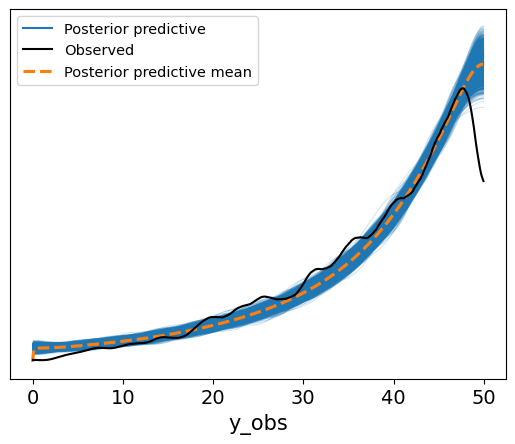

In [96]:
pm.plot_ppc(trace)

## Model comparison

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


/opt/anaconda3/envs/bayes2025_backup/lib/python3.12/site-packages/arviz/stats/stats.py:1045: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
/opt/anaconda3/envs/bayes2025_backup/lib/python3.12/site-packages/arviz/stats/stats.py:797: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/opt/anaconda3/envs/bayes2025_backup/lib/python3.12/site-packages/arviz/stats/stats.py:1045: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
/opt/anaconda3/envs/bayes2025_backup/lib/python3.12/site-packages/arviz/stats/stats.py:797: UserWarning: Esti

                       rank      elpd_loo       p_loo     elpd_diff  \
model_beta_luxury         0   6095.205936  669.597024      0.000000   
model_beta_heterosc4      1   6063.919057  562.258291     31.286879   
model_beta_m4             2   2925.935814    4.425256   3169.270122   
model_beta_m3             3   2922.121369    2.114678   3173.084567   
model_beta_m2             4   1717.683530   96.538077   4377.522406   
model_beta_m1             5   1703.819262    8.343014   4391.386674   
model_trunc_normal_m4     6  -8813.566367  100.392689  14908.772303   
model_binomial_m4         7  -9536.337426  680.528937  15631.543362   
model_binomial_m1         8 -29651.368871   78.366013  35746.574807   

                             weight          se         dse  warning scale  
model_beta_luxury      9.991133e-01   52.323425    0.000000     True   log  
model_beta_heterosc4   0.000000e+00   54.226947    4.886273     True   log  
model_beta_m4          0.000000e+00   35.428856   37.10007

<Axes: title={'center': 'Model comparison\nhigher is better'}, xlabel='elpd_loo (log)', ylabel='ranked models'>

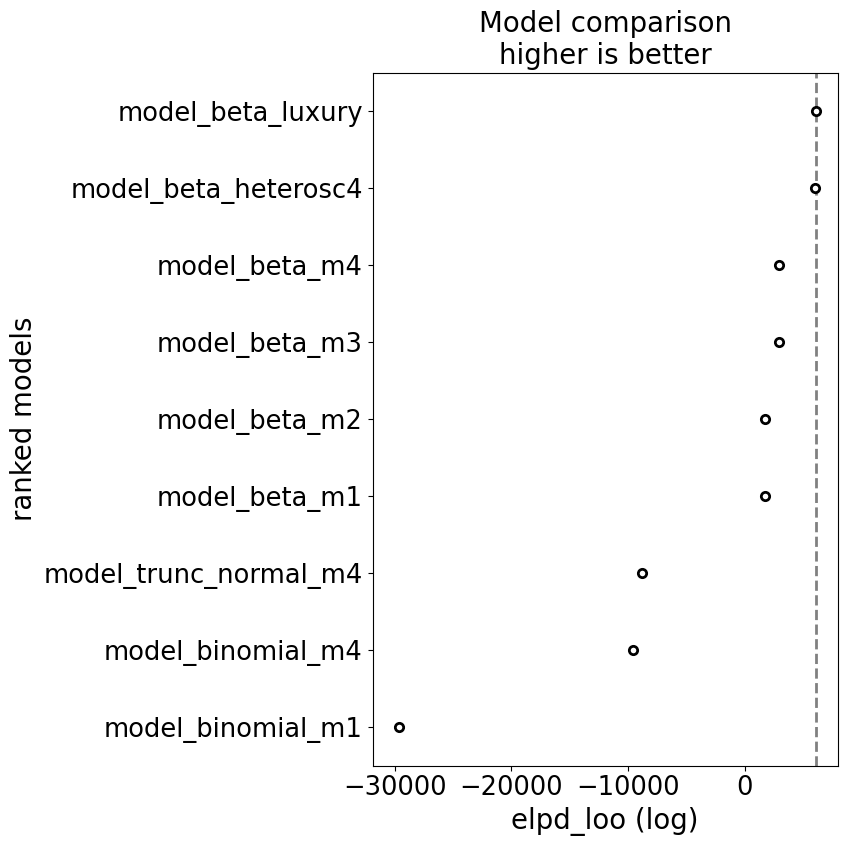

In [16]:
comp = az.compare(models, var_name='y_obs')
print(comp)
az.plot_compare(comp)

### Checking for overfit and underfit

In [20]:
def plot_calibration(
    estimates,
    obs,
    obs_var,
    n_bins=20,
    figsize=(10, 7),
    ax=None,
    add_uncertainty=False,
    n_bootstrap=None,
):
    """
    Plot calibration curve comparing HDI coverage to observed rates with optional uncertainty bands.

    Parameters
    ----------
    estimates : xarray.Dataset or dict
        Dataset or dictionary containing model predictions with shape (n_samples, n_observations)
    obs : array-like
        Array of true observed values with shape (n_observations,)
    obs_var : str
        Name of variable in estimates to compute coverage on
    n_bins : int, optional
        Number of probability bins for calibration curve, default 20
    figsize : tuple, optional
        Figure size as (width, height), default (10, 7)
    ax : matplotlib.axes.Axes, optional
        Matplotlib axis to plot on, default None creates new figure
    add_uncertainty : bool, optional
        Whether to add bootstrap uncertainty bands, default False
    n_bootstrap : int, optional
        Number of bootstrap samples for uncertainty estimation, default None

    Returns
    -------
    matplotlib.axes.Axes
        The axis containing the calibration plot
    """
    if add_uncertainty:
        probs, stats, lower, upper = compute_coverage(
            estimates, obs, obs_var, n_bins, add_uncertainty, n_bootstrap
        )
    else:
        probs, stats = compute_coverage(
            estimates, obs, obs_var, n_bins, add_uncertainty, n_bootstrap
        )

    if ax is None:
        _, ax = plt.subplots(figsize=figsize)

    # Plot diagonal reference line
    ax.plot([0, 100], [0, 100], "k--", alpha=0.5, label="Perfect Calibration")

    if add_uncertainty:
        ax.fill_between(
            probs * 100,
            lower,
            upper,
            color="forestgreen",
            alpha=0.2,
            label="95% Bootstrap CI",
        )

    # Plot main calibration curve
    ax.scatter(
        probs * 100, stats, color="forestgreen", alpha=0.6, label="Observed Coverage"
    )

    ax.set(xlabel="HDI Probability", ylabel="Coverage", title="Calibration Plot")
    ax.legend()

    return ax


def compute_coverage(estimates, obs, obs_var, n_bins, add_uncertainty, n_bootstrap):
    """
    Compute coverage statistics and optional bootstrap uncertainty bounds.

    Parameters
    ----------
    estimates : xarray.Dataset or dict
        Dataset containing model predictions
    obs : array-like
        Array of true observed values
    obs_var : str
        Name of variable in estimates to compute coverage on
    n_bins : int
        Number of probability bins
    add_uncertainty : bool
        Whether to compute bootstrap uncertainty bounds
    n_bootstrap : int
        Number of bootstrap samples

    Returns
    -------
    tuple
        If add_uncertainty=False: (probs, stats)
        If add_uncertainty=True: (probs, stats, lower_bound, upper_bound)
        where:
            probs : array of HDI probabilities
            stats : array of coverage statistics
            lower_bound : array of lower 95% CI bounds
            upper_bound : array of upper 95% CI bounds
    """
    probs = np.linspace(0.01, 0.99, n_bins)
    stats = []

    for prob in probs:
        stats.append(coverage_stat(estimates[obs_var], obs, prob).item())
        #stats.append(coverage_stat(estimates[obs_var], obs, prob)[obs_var].item())
    stats = np.array(stats)

    if add_uncertainty:
        bootstrap_stats = np.zeros((n_bootstrap, len(probs)))
        n_obs = len(obs)

        for i in range(n_bootstrap):
            idx = np.random.choice(n_obs, size=n_obs, replace=True)
            for j, prob in enumerate(probs):
                bootstrap_stats[i, j] = coverage_stat(
                    estimates[obs_var][..., idx], obs[idx], prob
                )[obs_var].item()

        lower = np.percentile(bootstrap_stats, 2.5, axis=0)
        upper = np.percentile(bootstrap_stats, 97.5, axis=0)

        return probs, stats, lower, upper

    return probs, stats


def coverage_stat(estimates, obs, hdi_prob):
    """
    Calculate the coverage statistic for a given HDI probability.

    Parameters
    ----------
    estimates : array-like
        Array of model predictions
    obs : array-like
        Array of true observed values
    hdi_prob : float
        Probability level for HDI calculation (between 0 and 1)

    Returns
    -------
    float
        Percentage of observations falling within the HDI
    """
    hdi = az.hdi(estimates, hdi_prob=hdi_prob)
    is_in_hdi = (obs >= hdi.sel(hdi="lower")) & (obs <= hdi.sel(hdi="higher"))
    return is_in_hdi.mean() * 100

KeyError: '[2819, 3638, 778, 3034, 2541, 2430, 2597, 868, 410, 2270, 203, 2800, 2083, 1505, 2458, 1794, 3577, 1327, 1480, 3450, 3401, 3187, 3280, 1811, 3325, 1524, 776, 2710, 1877, 1916, 596, 547, 1863, 43, 1719, 1904, 2062, 2577, 2174, 1989, 1525, 2999, 3805, 2914, 3194, 782, 3923, 615, 2734, 3175, 345, 859, 145, 3889, 336, 3146, 2723, 1471, 395, 3336, 3783, 2938, 3885, 2169, 2136, 2615, 910, 1388, 1537, 2673, 1964, 854, 2282, 3891, 3667, 1538, 3327, 3079, 3996, 2562, 3879, 3115, 2940, 1883, 664, 979, 2897, 1094, 2808, 551, 1605, 3980, 201, 1066, 2778, 3481, 701, 3571, 3725, 3075, 3546, 905, 3026, 972, 389, 667, 403, 1974, 774, 3122, 339, 2972, 2624, 1153, 2548, 3332, 1430, 2288, 3734, 3702, 1064, 1217, 349, 3672, 639, 3243, 2529, 2697, 3649, 1269, 684, 1734, 1442, 780, 3919, 3615, 2185, 3508, 3992, 914, 1485, 2928, 2463, 1818, 930, 2419, 3494, 3109, 676, 61, 334, 2290, 2566, 1087, 2688, 1109, 1641, 1993, 565, 1348, 2633, 167, 2134, 1575, 3596, 180, 2491, 1857, 1500, 557, 2379, 3101, 2535, 2115, 2572, 1936, 2953, 73, 625, 2593, 1508, 2439, 2900, 3036, 3202, 2093, 3178, 1267, 1041, 3005, 3979, 2967, 2418, 618, 1130, 1253, 586, 2183, 1007, 3055, 457, 3690, 3168, 2143, 3226, 3403, 3152, 1784, 315, 1226, 517, 3512, 3798, 1002, 3062, 487, 156, 1506, 2142, 1454, 2781, 1369, 3039, 633, 3221, 1778, 673, 1205, 1321, 858, 1457, 1202, 721, 3276, 104, 1401, 3246, 2233, 244, 650, 1081, 3822, 1304, 3234, 3552, 3753, 641, 992, 2730, 251, 375, 2364, 3899, 39, 796, 3550, 1639, 606, 755, 789, 2754, 2446, 342, 3929, 663, 3160, 1340, 2323, 764, 1793, 3131, 2948, 2751, 2149, 529, 1263, 1096, 2656, 834, 912, 193, 227, 458, 105, 316, 3150, 1159, 2228, 3052, 3729, 3599, 1557, 3532, 3952, 3833, 1988, 340, 2045, 3886, 219, 1869, 2944, 746, 1452, 690, 1797, 65, 212, 680, 2696, 353, 1074, 3133, 711, 806, 1796, 3278, 909, 3064, 1957, 1354, 452, 1701, 3342, 2124, 696, 3284, 3513, 3499, 442, 861, 1090, 1095, 2094, 1230, 2747, 2469, 1394, 2473, 3633, 2786, 2107, 1990, 1851, 2729, 2598, 2711, 1011, 2903, 2367, 693, 1961, 3675, 2063, 440, 597, 215, 189, 2042, 2054, 3652, 1194, 3483, 3008, 3739, 1010, 797, 1193, 881, 176, 1332, 3085, 1624, 3320, 2158, 3013, 2905, 532, 2973, 1644, 1700, 626, 1614, 1921, 3948, 827, 2902, 1702, 2472, 2477, 737, 2180, 1859, 2259, 3116, 2360, 3750, 2428, 2140, 712, 1625, 2382, 1862, 520, 1141, 1254, 1946, 1731, 1391, 348, 768, 147, 713, 2353, 3664, 622, 2417, 2817, 2148, 975, 13, 3038, 1588, 1272, 2779, 1477, 2678, 186, 3186, 2823, 2704, 2980, 3047, 1115, 672, 3331, 3861, 2191, 1513, 2133, 1075, 2017, 3188, 1522, 989, 2963, 2349, 3687, 2316, 2453, 1487, 117, 56, 3540, 3128, 1800, 3157, 3166, 1558, 3761, 2837, 3028, 1735, 2691, 709, 2105, 1175, 55, 3629, 2131, 2238, 3732, 1578, 3076, 1133, 2725, 2760, 3817, 24, 2166, 1104, 2283, 1201, 3626, 370, 894, 1351, 184, 3233, 385, 376, 860, 2917, 3182, 1288, 949, 3926, 1199, 1335, 788, 3775, 3742, 3755, 3616, 2918, 2435, 511, 3431, 3815, 1110, 753, 1455, 3423, 3364, 3726, 3312, 1996, 1672, 2043, 443, 3829, 3238, 2088, 3677, 3104, 1168, 57, 1610, 2707, 2412, 2872, 1469, 902, 3717, 2444, 2304, 2345, 3999, 1144, 584, 2603, 2893, 3964, 541, 3311, 393, 3084, 3740, 2198, 2608, 2908, 1436, 2563, 1291, 1161, 172, 2814, 2132, 3975, 2207, 2294, 1386, 3618, 3257, 1238, 2636, 2390, 1920, 40, 2632, 2494, 974, 961, 481, 3066, 3758, 2388, 476, 3762, 3845, 924, 678, 344, 1050, 355, 3422, 1655, 743, 2575, 2873, 2413, 3465, 3982, 1919, 1067, 1768, 1539, 938, 1082, 3387, 111, 2232, 1294, 2383, 3087, 3140, 164, 2609, 559, 543, 3348, 3490, 1209, 1056, 3002, 3921, 1976, 1237, 1779, 2576, 2648, 1496, 3924, 2445, 3011, 2004, 3185, 341, 2524, 2072, 2755, 3679, 3959, 136, 329, 549, 2657, 2040, 1638, 1720, 3876, 122, 2879, 1128, 200, 1107, 401, 568, 2768, 2616, 1690, 710, 1907, 3602, 3129, 720, 1156, 1840, 2936, 2887, 563, 157, 417, 2402, 1570, 1754, 185, 3656, 637, 363, 2743, 1116, 2640, 113, 1445, 760, 1027, 3988, 1029, 1155, 1937, 3730, 1873, 2235, 1662, 2408, 2719, 1933, 2868, 2596, 2028, 3913, 3578, 1456, 1670, 659, 2499, 3065, 1884, 2326, 1026, 2720, 2504, 1137, 3670, 1721, 1849, 1594, 1781, 2604, 2103, 671, 3686, 3295, 811, 2935, 994, 3333, 2038, 3035, 3907, 3487, 1709, 3529, 3511, 357, 2340, 2114, 328, 1235, 1177, 2249, 2055, 1099, 727, 1173, 3747, 3307, 2489, 3380, 3145, 3004, 3141, 1400, 1410, 3095, 350, 3452, 940, 1053, 3846, 2848, 1567, 3575, 731, 1049, 3558, 2337, 1848, 756, 623, 3303, 1307, 1983, 3768, 2479, 173, 174, 1315, 3451, 2506, 580, 2271, 1791, 1714, 2984, 99, 1252, 3239, 955, 1748, 3049, 2880, 3345, 1517, 1167, 3153, 965, 3290, 3103, 2217, 162, 3816, 1846, 2744, 3444, 3956, 645, 2066, 2765, 2862, 3442, 600, 3231, 500, 290, 3486, 392, 3859, 3716, 3993, 2096, 1900, 2381, 2090, 1577, 471, 1398, 1788, 1325, 1583, 2474, 1223, 3530, 2605, 691, 3862, 3092, 3094, 493, 228, 1086, 1196, 3289, 2407, 738, 3790, 988, 3764, 1689, 2315, 736, 3711, 1478, 874, 3601, 3334, 29, 32, 956, 3718, 2223, 2761, 3551, 3539, 22, 462, 2558, 3357, 2959, 2291, 2172, 2543, 2245, 2931, 1319, 571, 194, 1984, 293, 2985, 3593, 1495, 3838, 1498, 624, 2127, 921, 1757, 3757, 1785, 2922, 2726, 2400, 1222, 918, 2324, 3102, 815, 514, 496, 513, 3689, 2269, 2137, 76, 3273, 531, 2293, 1764, 2916, 2933, 2877, 1070, 3316, 3355, 233, 1924, 3835, 3113, 1839, 2789, 1831, 516, 3814, 3197, 2620, 169, 917, 288, 3653, 1039, 245, 1431, 246, 2716, 2302, 469, 2007, 2724, 3057, 324, 840, 984, 981, 2924, 2144, 3191, 2482, 2871, 735, 2526, 2312, 1216, 488, 2677, 2512, 3676, 3620, 2037, 786, 1763, 1045, 862, 758, 1985, 880, 286, 284, 3853, 279, 2553, 1516, 976, 3265, 509, 1881, 1297, 3051, 952, 3405, 2554, 2361, 654, 751, 1450, 1515, 1059, 2979, 3485, 1318, 2991, 1956, 1585, 3933, 2676, 2451, 2830, 2485, 3925, 2033, 3922, 971, 2139, 1998, 439, 1180, 2236, 3699, 1448, 391, 3580, 1922, 1669, 1429, 2420, 3500, 2907, 2834, 2508, 3787, 3329, 1795, 3994, 479, 1224, 1036, 2261, 1413, 2863, 2646, 2082, 218, 3776, 384, 411, 2785, 869, 552, 848, 3484, 33, 1460, 3801, 3437, 2764, 853, 1003, 1264, 1298, 1722, 689, 3547, 3030, 3323, 1186, 3132, 3195, 2876, 3406, 1475, 2126, 818, 3411, 386, 2467, 3138, 1040, 2321, 2813, 3995, 3478, 2654, 2590, 3283, 434, 3509, 966, 1425, 1402, 1046, 2011, 837, 1462, 2853, 144, 93, 3634, 2925, 379, 2013, 769, 3024, 210, 583, 2683, 3535, 1077, 2549, 3349, 400, 507, 3248, 1905, 3488, 906, 2957, 206, 320, 3965, 2309, 1073, 2332, 3498, 236, 3300, 3930, 3304, 2034, 405, 1381, 556, 660, 669, 564, 3007, 3396, 2327, 3200, 274, 1030, 3967, 2279, 1025, 58, 326, 2591, 1338, 1553, 118, 2008, 54, 2490, 535, 1117, 2951, 1172, 1640, 3603, 1958, 242, 824, 3782, 3110, 530, 1971, 3232, 2642, 1889, 1105, 1940, 2284, 1931, 132, 2074, 3376, 177, 3201, 2542, 2242, 2165, 3719, 292, 2204, 3089, 508, 3544, 2437, 30, 3183, 3441, 581, 3252, 3433, 3029, 1274, 1415, 611, 1308, 3174, 3125, 1341, 1963, 213, 1371, 83, 1244, 333, 3070, 1228, 1185, 1009, 2560, 1852, 3928, 3843, 3896, 1271, 1903, 1212, 3080, 2651, 250, 3449, 2685, 1076, 1353, 2783, 1661, 3074, 3877, 2993, 901, 1048, 2373, 3865, 3698, 2201, 1057, 1607, 3918, 2869, 839, 373, 560, 2650, 2523, 1772, 1174, 3164, 1729, 2561, 2374, 2825, 3017, 1760, 3446, 619, 382, 3367, 2890, 267, 798, 1305, 3955, 3250, 2911, 1710, 742, 2565, 8, 1101, 1464, 2044, 3014, 2815, 3888, 3236, 1533, 1054, 578, 91, 2534, 2442, 2202, 3811, 3565, 2029, 314, 3154, 3541, 148, 2500, 1776, 2069, 2285, 1804, 358, 3253, 3322, 1943, 1089, 1825, 898, 160, 3314, 62, 1867, 3786, 3105, 159, 1484, 3468, 757, 3619, 1465, 1247, 2567, 522, 21, 1378, 3884, 338, 1221, 3419, 3668, 1218, 2818, 3830, 1759, 1098, 3555, 3443, 2699, 2434, 1694, 2335, 3373, 2192, 3954, 2286, 1724, 2455, 1747, 3561, 3362, 1744, 3472, 2346, 2906, 1733, 1643, 41, 1273, 2954, 270, 3895, 3235, 2301, 285, 967, 3010, 2135, 2578, 1535, 506, 652, 3564, 3467, 2728, 2509, 3340, 374, 3724, 536, 3461, 3654, 2687, 2085, 582, 2583, 3777, 1005, 1467, 845, 3808, 2745, 518, 1439, 1580, 1981, 1419, 3842, 3752, 1581, 765, 883, 70, 3630, 1200, 1830, 352, 1265, 323, 3218, 1771, 573, 2098, 3936, 3594, 1808, 1178, 2777, 2102, 2189, 1678, 1248, 1055, 1421, 235, 2026, 1986, 944, 3785, 3682, 2536, 2982, 897, 1550, 892, 3650, 3077, 705, 467, 1547, 1143, 2850, 3251, 1032, 2237, 3339, 3448, 3837, 192, 2178, 2630, 1463, 781, 1121, 1258, 2674, 3223, 34, 3828, 2589, 2518, 3445, 432, 2810, 1323, 3192, 533, 335, 2276, 2415, 610, 3582, 2262, 3172, 1783, 303, 3023, 1816, 1259, 1122, 616, 1277, 1372, 2559, 3903, 3196, 1691, 1234, 1821, 1408, 2056, 1845, 3850, 18, 1680, 794, 537, 1065, 2763, 2774, 2878, 2915, 2718, 1716, 1870, 3741, 3270, 822, 2128, 3466, 3977, 2539, 2766, 3962, 2503, 1540, 879, 630, 1708, 19, 1343, 494, 546, 1611, 1692, 978, 2794, 3569, 1504, 1420, 1397, 920, 665, 3820, 1488, 706, 3584, 1792, 2221, 617, 1240, 3159, 2531, 3803, 2913, 1822, 1895, 3836, 2344, 801, 964, 1149, 296, 3151, 538, 1000, 3053, 1531, 1148, 1299, 748, 2394, 2123, 644, 287, 85, 3713, 823, 1519, 1083, 406, 2031, 728, 3454, 2152, 2587, 3644, 2108, 1966, 46, 3297, 2208, 642, 1233, 322, 2701, 2303, 887, 1147, 3990, 2092, 2840, 2975, 368, 2614, 2368, 2552, 1626, 723, 2888, 3464, 241, 3229, 1975, 2414, 734, 2735, 1120, 171, 3949, 3063, 1707, 937, 2715, 2962, 1418, 2585, 3020, 3120, 1447, 1028, 1589, 512, 255, 2824, 1556, 1865, 3727, 2300, 1286, 1008, 3457, 3973, 2538, 1713, 3046, 2342, 2145, 2241, 3324, 3774, 2727, 3361, 2277, 674, 1586, 1812, 3244, 1927, 2396, 3804, 237, 1740, 3705, 2652, 3613, 2116, 1842, 805, 791, 96, 3765, 2990, 2478, 1874, 773, 2097, 2976, 666, 1249, 302, 263, 2220, 1952, 2974, 3308, 885, 1651, 1123, 2460, 3704, 2343, 1612, 3953, 2733, 305, 2440, 119, 86, 1152, 1677, 1829, 904, 2909, 3910, 2746, 1706, 163, 2515, 3249, 421, 254, 686, 3526, 2702, 3659, 2244, 3319, 3549, 3459, 3391, 593, 1255, 1606, 3420, 888, 3271, 378, 1530, 3435, 1696, 3330, 1836, 793, 3589, 2602, 3908, 1835, 298, 1573, 295, 3112, 3100, 643, 3394, 2516, 3393, 3797, 3060, 1894, 383, 1097, 3293, 2199, 3082, 1483, 1973, 1393, 2488, 1473, 2110, 821, 1637, 1451, 1282, 51, 3779, 1563, 67, 1426, 648, 1755, 2077, 3042, 3628, 243, 2399, 2695, 3857, 1753, 2397, 2229, 1541, 838, 1660, 3826, 2795, 3432, 354, 2653, 1890, 872, 3673, 1020, 1368, 3794, 362, 387, 2612, 2507, 299, 1875, 2708, 1860, 521, 491, 2015, 692, 26, 953, 3428, 449, 3266, 3213, 632, 540, 813, 1364, 2424, 66, 716, 2313, 2391, 3255, 3415, 3219, 2898, 474, 2427, 3598, 1251, 1514, 2416, 1503, 2574, 3054, 3356, 2273, 2150, 31, 50, 882, 1384, 319, 1604, 3111, 2147, 3622, 1834, 2230, 1038, 534, 1379, 2206, 1657, 199, 265, 1350, 3793, 2356, 3683, 871, 3096, 2852, 548, 2194, 2611, 945, 2767, 2641, 1404, 2130, 1767, 3700, 1770, 2594, 1446, 2225, 14, 198, 2844, 779, 2930, 1666, 3897, 1357, 2395, 1004, 891, 3377, 3214, 1022, 3407, 1718, 3917, 3189, 2821, 3771, 640, 103, 281, 2947, 2568, 1841, 3358, 2923, 3645, 3018, 1528, 3760, 3414, 112, 2570, 2385, 1853, 372, 135, 750, 592, 3069, 1872, 1135, 308, 98, 141, 3027, 3941, 82, 3413, 1043, 1959, 3427, 2177, 2891, 2258, 1546, 2638, 3363, 224, 3642, 3006, 2797, 785, 397, 3044, 2296, 1292, 719, 3462, 3081, 100, 2264, 2461, 2803, 3025, 3350, 460, 1444, 1078, 2188, 3763, 427, 3171, 3612, 1972, 3161, 1743, 2227, 2955, 2061, 2274, 609, 2971, 456, 3684, 2, 461, 2492, 71, 3516, 1146, 297, 3108, 412, 3819, 2320, 1925, 1260, 951, 2790, 3059, 1301, 2389, 3292, 110, 935, 2843, 638, 1290, 2983, 3318, 1893, 2619, 1459, 1758, 1856, 2586, 3299, 502, 2942, 168, 1636, 1068, 3969, 330, 3086, 3563, 1745, 762, 889, 1466, 3501, 3560, 3832, 3317, 211, 3370, 3681, 311, 1035, 2322, 653, 2706, 2842, 1411, 1181, 982, 1360, 1440, 3568, 2772, 1773, 2190, 2502, 3398, 1158, 3583, 926, 418, 182, 430, 68, 3032, 2894, 294, 1365, 154, 1320, 3624, 483, 92, 89, 799, 3425, 1375, 3703, 900, 809, 3230, 1111, 931, 3920, 2186, 2626, 2433, 3493, 3424, 2732, 7, 261, 2776, 3268, 2899, 3368, 3199, 2943, 53, 1382, 252, 1063, 3163, 683, 3795, 2564, 657, 3000, 1311, 787, 3479, 2118, 2371, 2278, 1245, 459, 1912, 2325, 1824, 1363, 2366, 1802, 1231, 576, 2234, 3852, 1387, 1207, 3041, 3945, 3960, 2012, 3301, 598, 2717, 2532, 528, 1969, 2075, 2057, 3313, 2748, 3637, 3632, 2533, 88, 420, 1686, 3989, 1339, 346, 3518, 1688, 3869, 725, 3091, 504, 480, 3880, 3914, 3770, 1634, 2101, 2658, 1497, 876, 3489, 2036, 913, 928, 1615, 2450, 2610, 149, 3707, 3416, 1134, 843, 125, 3863, 3068, 2153, 2305, 3031, 3981, 2968, 2129, 109, 1617, 1935, 3430, 1309, 3940, 1165, 3099, 3678, 687, 2629, 3784, 3279, 433, 3640, 2666, 3495, 230, 2184, 852, 833, 3190, 1395, 1923, 1671, 1970, 1119, 603, 2670, 20, 1403, 3341, 2370, 550, 3548, 2581, 729, 1112, 3738, 3915, 407, 2452, 1566, 2758, 1960, 3354, 2495, 3824, 1243, 369, 855, 3470, 2175, 1629, 1092, 2895, 2771, 2406, 3557, 2686, 503, 3090, 3207, 2058, 1151, 2664, 36, 960, 2311, 3655, 1679, 2046, 453, 2816, 2475, 2645, 3088, 865, 2510, 1015, 2287, 75, 2448, 3978, 1591, 388, 3904, 3177, 1886, 1828, 1154, 1220, 3421, 835, 1599, 3611, 2272, 1256, 217, 2756, 3791, 3058, 636, 1697, 1140, 3117, 2528, 2125, 1088, 361, 425, 3343, 337, 3395, 309, 3475, 1361, 2964, 1191, 1854, 1780, 276, 2211, 1016, 275, 1887, 2193, 3802, 590, 3756, 2095, 3522, 2722, 1453, 1658, 3227, 3536, 567, 2051, 0, 2580, 155, 771, 1214, 3847, 3447, 585, 2341, 2623, 2081, 3056, 3987, 47, 1803, 1163, 699, 2926, 1810, 3365, 3474, 106, 1060, 2956, 3155, 1326, 1741, 830, 1470, 3519, 1913, 1166, 3184, 1501, 260, 2195, 2864, 987, 3114, 1949, 477, 3666, 318, 3360, 2001, 2750, 2170, 2112, 3736, 829, 1468, 423, 3305, 2582, 3126, 2540, 15, 1103, 3137, 2721, 577, 204, 1549, 1281, 3872, 312, 2804, 515, 2851, 266, 1909, 1062, 651, 3605, 414, 1742, 2257, 3515, 2757, 2354, 472, 936, 2514, 2934, 527, 1198, 3623, 2798, 1169, 2571, 3658, 3812, 1579, 3205, 2631, 2480, 2070, 1352, 1826, 941, 2016, 2401, 231, 2306, 3831, 761, 2347, 1213, 1994, 1499, 2025, 3867, 2484, 1876, 499, 3769, 1725, 1628, 1855, 1543, 59, 3346, 588, 3134, 890, 2173, 3723, 2253, 2855, 3167, 2801, 253, 682, 3608, 2511, 3179, 2333, 2742, 2067, 138, 1908, 739, 2216, 1270, 3559, 3390, 870, 1362, 3139, 2138, 3985, 2215, 278, 627, 3685, 454, 3517, 1482, 87, 1472, 1858, 3695, 3269, 864, 116, 599, 1179] not in index'

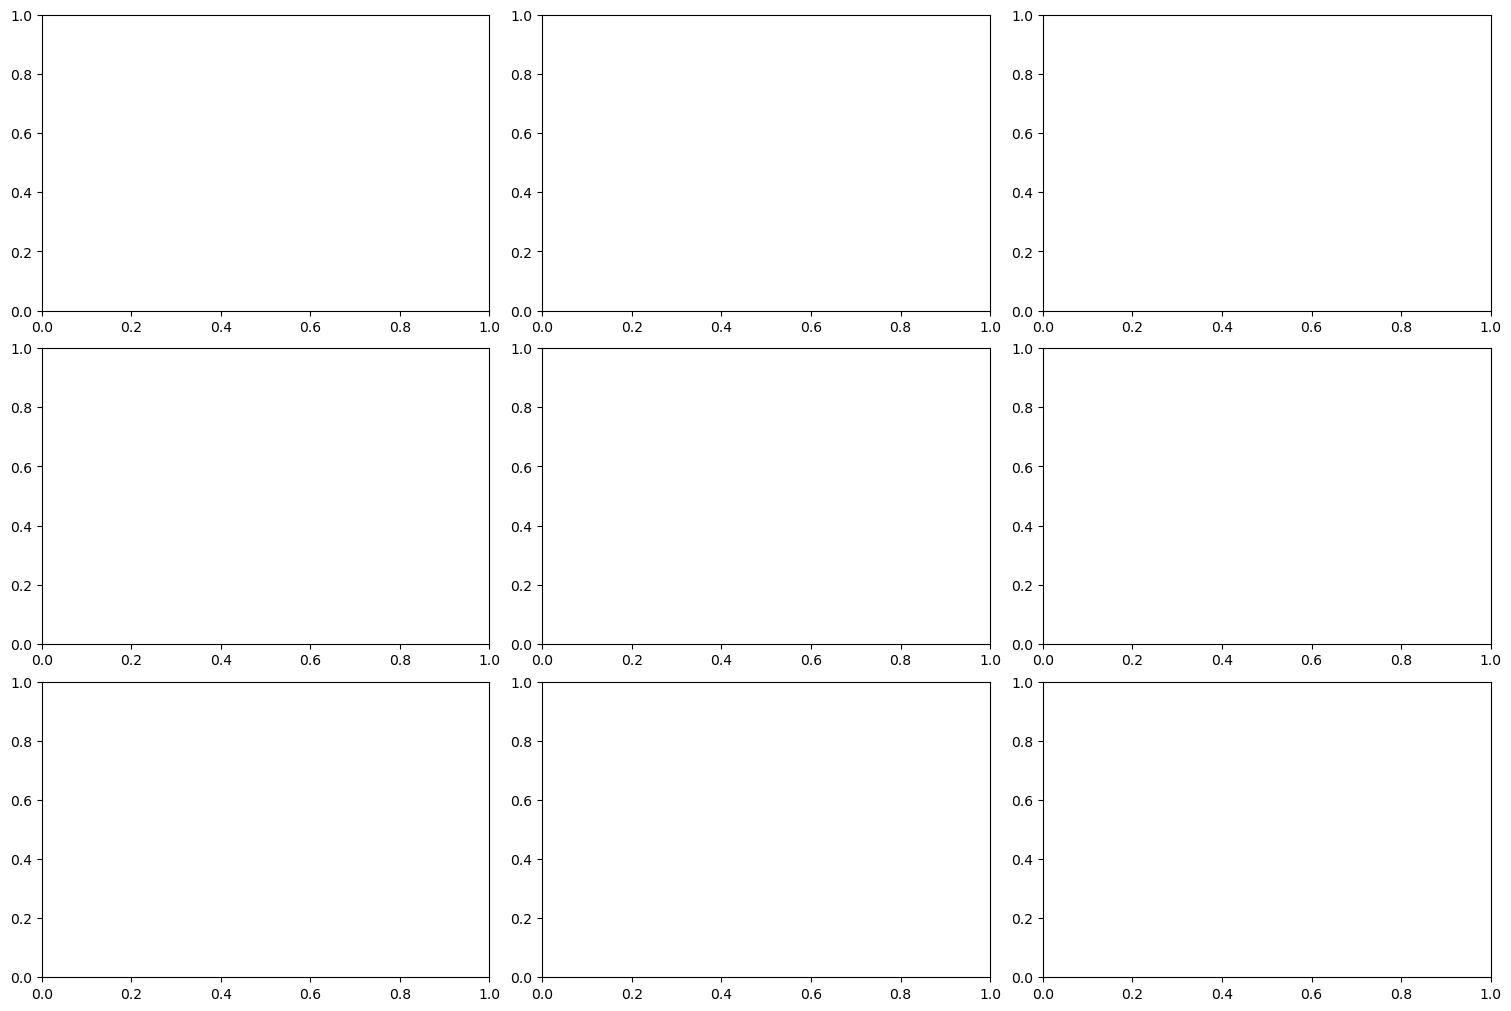

In [21]:
# | column: page
# | label: fig-calibration-train
# | fig-cap: "X% of the observed strikeout rates (y-axis) fell within the X% HDI (x-axis)"


_, axes = plt.subplots(3, 3, figsize=(15, 10), constrained_layout=True)
for (name, trace), ax in zip(models.items(), axes):
    ax = plot_calibration(
        trace.posterior_predictive,
        df.exam_score,
        "y_obs",
        ax=ax,
        add_uncertainty=True,
        n_bootstrap=30,
    )
    ax.set_title(f"{name} Model")
    #ax.legend() if name == "Underfit" else ax.legend([], frameon=False)

In [18]:
models.items()

dict_items([('model_beta_m1', Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> observed_data), ('model_beta_m2', Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> observed_data), ('model_beta_m3', Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> observed_data), ('model_beta_m4', Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> observed_data), ('model_beta_heterosc4', Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> observed_data), ('model_beta_luxury', Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> observed_data), ('model_binomial_m1', Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> observed_data), ('model_binomial_m4',